<a href="https://colab.research.google.com/github/gabbiurlaro/aml22-ego/blob/vae/augment_datset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSTALL AND GIT


In [1]:
!rm -rf sample_data

!git clone https://github.com/gabbiurlaro/aml22-ego.git aml22-ego
!cd aml22-ego && git checkout vae

Cloning into 'aml22-ego'...
remote: Enumerating objects: 4115, done.
remote: Counting objects: 100% (767/767), done.
remote: Compressing objects: 100% (301/301), done.
remote: Total 4115 (delta 518), reused 708 (delta 465), pack-reused 3348
Receiving objects: 100% (4115/4115), 1.52 GiB | 27.83 MiB/s, done.
Resolving deltas: 100% (2984/2984), done.
Updating files: 100% (45/45), done.
Updating files: 100% (176/176), done.
Branch 'vae' set up to track remote branch 'vae' from 'origin'.
Switched to a new branch 'vae'


In [2]:
# Mount google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Install conda

!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:10
🔁 Restarting kernel...


In [4]:
!mkdir -p /usr/local/envs/egovision
!tar xf /content/drive/MyDrive/egovision.tar.gz --directory=/usr/local/envs/egovision

# EMG Preprocessing


In [2]:
%%bash
cd aml22-ego
pip install coloredLogs
pip install omegaConf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!cd aml22-ego && git pull origin vae
import utils
import torch.nn.parallel
import torch.optim
import torch
import utils
import utils.loaders
from utils.loaders import ActionNetDataset
import utils
import numpy as np
import os
import pickle
from omegaconf import OmegaConf

d = OmegaConf.create({'annotations_path': '../drive/MyDrive/train_val_EMG', 'stride': 2})
loader = torch.utils.data.DataLoader(ActionNetDataset('ActionNet', ['EMG'], 'train', d, {'EMG': 32}, 5, {'EMG': False}, None, load_feat=False, additional_info=None, kwargs={"require_spectrogram": True}),
                                                        batch_size=1, shuffle=False,
                                                        num_workers=2, pin_memory=True, drop_last=True)


From https://github.com/gabbiurlaro/aml22-ego
 * branch            vae        -> FETCH_HEAD
Already up to date.


ModuleNotFoundError: ignored

In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import pandas as pd

processed_data = []
emg_signals = pd.DataFrame(pd.read_pickle('/content/drive/MyDrive/train_val_EMG/ActionNet_train.pkl'))

In [8]:
emg_signals['myo_left_readings'][200].shape, emg_signals['myo_right_readings'][200].shape

((2038, 8), (2038, 8))

In [51]:
for emg_signal in loader:
  # Assuming your input EMG signal is stored in a PyTorch tensor called 'emg_signal'
  # Assuming your input EMG signal is stored in a PyTorch tensor called 'emg_signal'
  emg_signal = emg_signal.view(16, -1)  # Reshape to (16, 1024)
  # Rectify the signal on each channel
  rectified_signal = torch.abs(emg_signal)


    # Design a low-pass filter using a cutoff frequency of 5Hz
  cutoff_freq = 5.0
  nyquist_freq = 0.5 * 10  # Nyquist frequency for the target sample rate of 10Hz
  normalized_cutoff = cutoff_freq / nyquist_freq
  filter_order = 3  # Adjust filter order as per your requirements

  # Apply the low-pass filter to each channel
  filtered_signal = torch.zeros_like(rectified_signal)
  for channel_idx in range(filtered_signal.shape[0]):
      filtered_signal[channel_idx] = F.lowpass_biquad(rectified_signal[channel_idx], normalized_cutoff, filter_order)

    # Jointly normalize the signal across all channels using the minimum and maximum values
  min_value = filtered_signal.min()
  max_value = filtered_signal.max()
  normalized_signal = 2 * (filtered_signal - min_value) / (max_value - min_value) - 1
  processed_data.append(normalized_signal)

processed_data = torch.stack(processed_data)
processed_data.mean(axis=0)

NameError: ignored

In [48]:
import numpy as np 
np.array([emg_signals['myo_left_readings'][i].shape for i in range(len(emg_signals['myo_left_readings']))]).min()

8

# Augmentation

In [ ]:
import pickle 
import numpy as np
import pandas as pd
import pywt
import torch
import os
import torch.nn.functional as F
from scipy.interpolate import CubicSpline
import random
import torchvision.transforms
from torch.utils.data import Dataset

train =  pd.DataFrame(pd.read_pickle('/content/aml22-ego/saved_features/ACTIONNET_EMG/EMG_no-clip_ActionNet_train.pkl'))
test =  pd.DataFrame(pd.read_pickle('/content/aml22-ego/saved_features/ACTIONNET_EMG/EMG_no-clip_ActionNet_test.pkl'))
original_train = pd.DataFrame(pd.read_pickle('/content/drive/MyDrive/train_val_EMG/ActionNet_train.pkl'))
original_test = pd.DataFrame(pd.read_pickle('/content/drive/MyDrive/train_val_EMG/ActionNet_test.pkl'))
original_train

In [ ]:
from utils.loaders import ActionNetDataset
sigma = 0.1
wavelet_name = 'db7' #Wavelet name (e.g., Daubechies 4)
decomposition_level = 5 # # Number of decomposition levels
detail_factor = 0 # Scaling factor for modifying detail coefficients
  
num_clips = 5
batch_Size = 1


train =  ActionNetDataset('ActionNet', ['EMG'], 'train', {'stride': 2, 'annotations_path':'/content/drive/MyDrive/train_val_EMG'}, {'EMG': 32}, 5, {'EMG': False},
                                                                       None, load_feat=False, additional_info=True)
#pd.DataFrame(pd.read_pickle('/content/aml22-ego/saved_features/ACTIONNET_EMG/EMG_no-clip_ActionNet_train.pkl'))
test =  ActionNetDataset('ActionNet', ['EMG'], 'test', {'stride': 2, 'annotations_path':'/content/drive/MyDrive/train_val_EMG'}, {'EMG': 32}, 5, {'EMG': False},
                                                                       None, load_feat=False,  additional_info=True)

train.list_file

In [ ]:
def wavelet_decomposition(signal, wavelet_name, decomposition_level, detail_factor):
    #print('WD :', signal.shape)
    coeffs = pywt.wavedec(signal, wavelet=wavelet_name, level=decomposition_level)
    cA, cD = coeffs[0], coeffs[1:]  # Approximation and detail coefficients
    
    # Modify detail coefficients
    cD_modified = [detail_factor * cd for cd in cD]
    
    # Reconstruct the augmented signal
    augmented_coeffs = [cA] + cD_modified
    augmented_signal = torch.tensor(pywt.waverec(augmented_coeffs, wavelet=wavelet_name))
    
    return augmented_signal


class WaveletDecompositionTransform:
    def __init__(self, wavelet_name, decomposition_level, detail_factor, num_clips):
        self.wavelet_name = wavelet_name
        self.decomposition_level = decomposition_level
        self.detail_factor = detail_factor
        self.num_clips = num_clips
    
    def __call__(self, sample):
        signals = sample['features_EMG']
        augmented_signals = []
        for i in range(self.num_clips):
          
          augmented_signals.append(wavelet_decomposition(signals[i], self.wavelet_name, self.decomposition_level, self.detail_factor))
        # Create a new augmented sample
        augmented_sample = {
            'features_EMG': torch.stack(augmented_signals).reshape(5, 16, 32, 32),
            'label': sample['label'],
            'uid': sample['uid'],
            'untrimmed_video_name': sample['untrimmed_video_name']
        }
        #print('WD',augmented_sample['features_EMG'].shape)
        
        return augmented_sample

In [ ]:
def magnitude_warping(signal, variance=0.01):
    T = signal.size(1)
    #print('MW :', T)
    t = torch.linspace(0, 1, T)  # Equidistant time points
    r = torch.randn(T)  # Random numbers from a normal distribution
    r = torch.clamp(r, -2.0, 2.0)  # Limit the range of random numbers to avoid extreme warping
    
    # Generate a smooth curve using cubic splines
    spline = CubicSpline(t, r)
    cubic_spline = torch.from_numpy(spline(t)).float()
    
    # Elementwise product of the interpolated curve with the signal
    warped_signal = torch.Tensor(signal * (1.0 + variance * cubic_spline))

    return warped_signal

class MagnitudeWarpingTransform:
    def __init__(self, variance, num_clips):
        self.variance= variance
        self.num_clips = num_clips
    
    def __call__(self, sample):
        signals = sample['features_EMG']
        augmented_signals = []
        for i in range(self.num_clips):
         # print('MW1: ', signals.shape)
          augmented_signals.append(magnitude_warping(signals[i], variance=self.variance))
        # Create a new augmented sample
        augmented_sample = {
            'features_EMG': torch.stack(augmented_signals),
            'label': sample['label'],
            'uid': sample['uid'],
            'untrimmed_video_name': sample['untrimmed_video_name']
        }
        
        return augmented_sample

# Example usage
#signal = torch.randn(1024)  # Assuming input signal of size 1024
#warped_signal = magnitude_warping(signal, variance=0.01)

In [ ]:
class Fit_Dims:
    def __init__(self, num_clips=5):
        
        self.num_clips = num_clips

    def __call__(self, x):
        signals = x[0]['EMG']
        signals = signals.reshape(5,16, 32, 32)
        #print(signals.shape)
        augmented_sample = {
              'features_EMG':signals,
              'label': x[1],
              'uid': x[3],
              'untrimmed_video_name': x[2]
          }
        #print(augmented_sample['features_EMG'].shape)
        return augmented_sample

In [ ]:
signal = train[0][0]['EMG']
signal = signal[0]
print('fd', type(signal), signal.shape)
x = signal.reshape(5,-1,32)
print('fd', type(x), x.shape)

fd <class 'torch.Tensor'> torch.Size([160, 32])
fd <class 'torch.Tensor'> torch.Size([5, 32, 32])


In [ ]:
%ls
for i in range(4):
  filename = './aug_original/ActionNet_augmented_clips_' + ts[i]
  with open(f"{filename}_train.pkl", "wb") as file:
            pickle.dump(outs[0][i], file)
  with open(f"{filename}_test.pkl", "wb") as file:
             pickle.dump(outs[1][i], file)

ACTIONNET/  ACTIONNET_EMG/  aug/  aug_original/  EPIC/  reconstructed/


In [ ]:
from google.colab import files
!zip -r /content/feats_augs.zip /content/aml22-ego/saved_features/ACTIONNET_EMG_AUG
files.download('/content/feats_augs.zip')

  adding: content/aml22-ego/saved_features/ACTIONNET_EMG_AUG/ (stored 0%)
  adding: content/aml22-ego/saved_features/ACTIONNET_EMG_AUG/job_feature_extraction_test_train.pkl (deflated 11%)
  adding: content/aml22-ego/saved_features/ACTIONNET_EMG_AUG/job_feature_extraction_train_train.pkl (deflated 11%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Plot features

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
num_clips = 5
# EPIC-KITCHEN and ActionNet

labels = {'EK':{
        0 : "take (get)",
        1 : "put-down (put/place)",
        2 : "open",
        3 : "close",
        4 : "wash (clean)",
        5 : "cut",
        6 : "stir (mix)",
        7 : "pour"
}, 'AN': {
        0 : "Spread",
        1 : "Get/Put",
        2 : "Clear",
        3 : "Slice",
        4 : "Clean",
        5 : "Pour",
        6 : "Load",
        7 : "Peel",
        8 : "Open/Close",
        9 : "Set",
        10 : "Stack",
        11 : "Unload"

}}

colors = {'EK': {
        0 : "#A52A2A",
        1 : "#DAA520",
        2 : "#FF7F50",
        3 : "#7BC8F6",
        4 : "#FFFF14",
        5 : "#76FF7B",
        6 : "#13EAC9",
        7 : "olive"
}, 'AN': {
        0 : "#A52A2A",
        1 : "#DAA520",
        2 : "#FF7F50",
        3 : "#7BC8F6",
        4 : "#FFFF14",
        5 : "#76FF7B",
        6 : "#13EAC9",
        7 : "olive",
        8 : "palegreen",
        9 : "lightpink",
        10 : "darkmagenta",
        11 : "cadetblue"
}}

In [3]:
data_original = pd.DataFrame(pd.read_pickle('/content/drive/MyDrive/ACTIONNET_EMG/job_feature_extraction_ActionNet_train.pkl')["features"])
data = pd.DataFrame(pd.read_pickle("/content/drive/MyDrive/EXTRACTED_FEATURES_AUG_1/Augmented_features_MW-WD_ActionNet_train.pkl")["features"])


In [ ]:
data.iloc[0]
ts = ['WD-MW', 'MW', 'WD', 'MW-WD']
data_augmented_train = []
for i in range(4):
  data_augmented_train.append(pd.read_pickle('/content/aml22-ego/saved_features/aug/ActionNet_augmented_clips_'+ ts[i]+'_train.pkl'))
data = pd.DataFrame(data_augmented_train[3]['features'] +data_augmented_train[2]['features']+
                   data_augmented_train[1]['features'] +
                    data_augmented_train[0]['features'] + data_original['features'])
len(data)

5


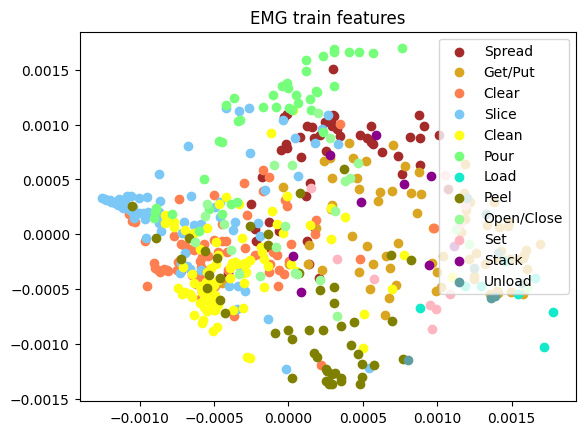

In [13]:
# plot emg features
print(len(data.iloc[0]['features_EMG']))
features = np.array([data.iloc[i].features_EMG[num_clips//2] for i in range(len(data))])
reduced = TSNE(learning_rate=0.001, early_exaggeration=12).fit_transform(features)
data['x'] = reduced[:, 0]
data['y'] = reduced[:, 1]
for i in range(12): # ek has 8 classes
    filtered = data[data["label"] == i]
    # compute the central frame
    plt.scatter(filtered['x'], filtered['y'], c=colors['AN'][i], label=labels['AN'][i])
plt.legend()
plt.title('EMG train features')
plt.show()

# Train VAE

In [ ]:
%%bash
#VAE EMG train and save

cd aml22-ego && git pull origin vae

PYTHON_PATH=/usr/local/envs/egovision/bin/python

$PYTHON_PATH train_VAE_features_EMG.py action="train_and_save" \
  name="VAE_EMG_2 full-aug lr1e-3 wkld1 sum" \
  config=configs/VAE_save_feat_EMG.yaml \
  dataset.shift=ActionNet-ActionNet \
  wandb_name='vae' \
  wandb_dir='Experiment_logs'  \
  dataset.RGB.data_path=../ek_data/frames \
  dataset.EMG.features_name='ACTIONNET_EMG/EMG_no-clip' \
  models.EMG.model='VAE' \
  models.EMG.lr=1e-3

# Train Classifier

In [ ]:
%%bash
ls
cd aml22-ego/
git stash
git pull origin vae

aml22-ego
condacolab_install.log
drive
feats_augs.zip
feats_def.zip
No local changes to save
Updating 85e3809..1d1dfd3
Fast-forward
 configs/classifier_emg.yaml                        |   1 +
 saved_features/.DS_Store                           | Bin 6148 -> 6148 bytes
 .../job_feature_extraction_test_train.pkl          | Bin 0 -> 249144 bytes
 .../job_feature_extraction_train_train.pkl         | Bin 0 -> 2227571 bytes
 train_classifier_EMG.py                            |  66 ++++++++++++++++-----
 utils/loaders.py                                   |   4 +-
 6 files changed, 53 insertions(+), 18 deletions(-)
 create mode 100644 saved_features/ACTIONNET_EMG_AUG/job_feature_extraction_test_train.pkl
 create mode 100644 saved_features/ACTIONNET_EMG_AUG/job_feature_extraction_train_train.pkl


From https://github.com/gabbiurlaro/aml22-ego
 * branch            vae        -> FETCH_HEAD
   8a8750c..1d1dfd3  vae        -> origin/vae


In [ ]:
%%bash
#classifier EMG train, validate and save

cd aml22-ego && git pull origin vae

PYTHON_PATH=/usr/local/envs/egovision/bin/python

$PYTHON_PATH train_classifier_EMG.py action="job_feature_extraction" name="job_feature_extraction" \
  config=configs/classifier_emg.yaml \
  dataset.shift=ActionNet-ActionNet \
  train.num_iter=50\
  wandb_name='vae'\
  wandb_dir='Experiment_logs'\
  dataset.RGB.data_path=../ek_data/frames  \
  models.EMG.model='EMG_classifier' \
  resume_from='./saved_models/EMG_classifier' \
  dataset.EMG.features_name='ACTIONNET_EMG/EMG_Normalized_no-clip' 

Already up to date.


From https://github.com/gabbiurlaro/aml22-ego
 * branch            vae        -> FETCH_HEAD
2023-05-24 20:35:32 LOG INFO Running with parameters: 
  action: job_feature_extraction
  name: job_feature_extraction
  modality: ['EMG']
  total_batch: 128
  batch_size: 32
  gpus: None
  wandb_name: vae
  resume_from: ./saved_models/EMG_classifier
  logname: job_feature_extraction_ActionNet-ActionNet.log
  models_dir: saved_models/job_feature_extraction/May24_20-35-31
  train:
    num_iter: 600
    lr_steps: 500
    eval_freq: 50
    num_clips: 1
    dense_sampling:
      RGB: True
      EMG: True
    num_frames_per_clip:
      RGB: 16
      EMG: 32
  save:
    num_clips: 5
    dense_sampling:
      RGB: True
      EMG: True
    num_frames_per_clip:
      RGB: 16
      EMG: 32
  test:
    num_clips: 5
    dense_sampling:
      RGB: True
      EMG: True
    num_frames_per_clip:
      RGB: 16
      EMG: 32
  dataset:
    annotations_path: ../drive/MyDrive/train_val_EMG
    shift: ActionNet-Acti

CalledProcessError: ignored